# Official public work with private tools

The controversy of Hilary Clinton's email hit the headlines in 2015. The goal of this project is to get a precise view of her network based on the emails publicly available on [Kaggle](https://www.kaggle.com/kaggle/hillary-clinton-emails). Unfortunately, the database is dirty as anyone could expect. Our work will be divided into the following tasks:

1. Clean the data and recover
2. Enrich the data
3. maybe go back to 1

At this point, drawing a basic graph should be possible.

4. Develop a system to cluster a document into a category
5. Show these categories in the final graph.

We remind that the goal of this milestone is as follows:

1. Handle the data in its size.

2. Understand the data (formats, distribution, missing values, correlations, etc.)

3. Consider a way to enrich, filter, transform the data according to your needs.

4. Update our plan in a reasonable way:
    
    4.1. Reflecting our improved knowledge after data acquaintance
    
    4.2. Discuss how your data suits our project needs 
    
    4.3. Discuss the methods that we will use, and provide the essential mathematical details
    
5. Show that the plan for analysis is reasonable, discussed considered choices but finally dropped


## Previously

As discussed in the first Milestone, we expected data cleaning, including text processing, handling missing values etc. as a major task of the Milestone. We considered that about 60-80% of our task (in the golbal Milestone) will be this. Without any surprise, we remark this expectation to be true. Indeed, database is dirty, really dirty... Although a lot of preprocess seemed to have been already done from the `rawText` of the `emails` database, we remark the latter to have been really poor. For example, in order to construct the Hillary's Network we need the exact `receiver` and `sender` of any emails. We remark some obvious mistakes in the Aliases correspondance with the personId for example. We explain deeper below the major difficulty that we have encountered and how we have finally handled them.

As said above, this Milestone focuses essentially on data cleaning and preprocess of rawText. Moreover, according to the questions and tasks we expect to provide, we have to clean and process data for the following features:

1. 'To' and 'From' (who receives and sends emails)

2. 'Date' (precise date of emails sending)

3. Extract content of emails (as good as possible), preprocess/clean

These three steps are crucial.

We present the plan.

## Plan

1. Data exploration 

    1.1. how are `aliases` and `personId` related ? 

    1.2. how clean are `MetaDataTo` ('To') and `MetaDataFrom` ('From') ? are there missing values ? 
    
    1.3. what is the behaviour of the content of `rawText` ? (is it messy, multi-emails, etc)
        
2. Data Cleaning and Processing

    2.1. Clean the `aliases` and `personId` relation
    
    2.2. Construction clean `To` and `From` features by processing and NaN filling
    
    2.3. Text cleaning for `rawText` (remove unappropriate lines)
    
    2.4. Text processing (lowcase, remove stopwords, remove short sentences, stemmatization, etc)
    
    2.5. Features engineering 
           
        2.5.0. Emails time distribution

        2.5.1. Map emails to countries/regions
        
        2.5.2. Word-frequency
        
        2.5.3. Research of thematics
        
3. Pre-results

    3.1. Adjacency matrix (Hillary's network) construction
    
    .....
        
3. Milestone 3, to be done: graph visu, map visu, 


## Data exploration

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk,gensim, sklearn, spacy
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.util import ngrams
from datetime import datetime, date, time
from gensim.models import word2vec
from sklearn.decomposition import PCA
from wordcloud import wordcloud
from PIL import Image
from os import path

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [2]:
data_folder = "../data/"

The data is available in two formats: csv and sql. This means that the elements are somehow related. We will see later that the entity relationship diagram is not as it should have been done.

In [3]:
#Data extraction from the csv-files
emails_raw = pd.read_csv(data_folder + 'Emails.csv')
persons = pd.read_csv(data_folder + 'Persons.csv')
aliases = pd.read_csv(data_folder + 'Aliases.csv')
email_receivers = pd.read_csv(data_folder + 'EmailReceivers.csv')

In [4]:
print("emails:", emails_raw.shape)
print("persons:", persons.shape)
print("aliases:", aliases.shape)
print("email receivers:", email_receivers.shape)

emails: (7945, 22)
persons: (513, 2)
aliases: (850, 3)
email receivers: (9306, 3)


For the moment, let's discover what we have. Extraction was performed according to some fields. Let us check whether or not we can rely on it.

In [5]:
persons.dtypes

Id       int64
Name    object
dtype: object

In [6]:
aliases.dtypes

Id           int64
Alias       object
PersonId     int64
dtype: object

##     1.1. how are `aliases` and `personId` related ? 


In [7]:
aliases.sort_values(by='PersonId')

,Id,Alias,PersonId
0,1,111th congress,1
1,2,agna usemb kabul afghanistan,2
2,3,ap,3
3,4,asuncion,4
4,5,alec,5
5,6,dupuy alex,6
6,7,american beverage association,7
7,8,mayock andrew,8
9,10,shapiroa@state.gov,9
8,9,shapiro andrew j,9


In [8]:
aliases.Alias

0                     111th congress
1       agna usemb kabul afghanistan
2                                 ap
3                           asuncion
4                               alec
5                         dupuy alex
6      american beverage association
7                      mayock andrew
8                   shapiro andrew j
9                 shapiroa@state.gov
10                slaughter annmarie
11              slaughter anne marie
12               slaughter annemarie
13              slaughtera@state.gov
14                      lake anthony
15               valenzuela arturo a
16            valenzuelaaa@state.gov
17                        kimoon ban
18                      obama barack
19                         president
20           bam@mikulski.senate.gov
21                      mikulski bam
22           mikulski bam (mikulski)
23          mikulski bam (mitkulski)
24            mikulskibam (mikulski)
25                     betsy.ebeling
26                     ebeling betsy
2

In [9]:
aliases.PersonId.is_unique

False

In [10]:
aliases.Alias.is_unique

True

### Remarks and Issues

`Aliases` is not to be unique per Aliases while `persons` is. Multiple obviously same Aliases point on a single person. We have to handle this in order to have an efficient database.

Moreover we remark that `Id` from the person dataframe is supposed to be unique by name. Obviously it is not the case. Indeed, considering the `Id` 512 and 513 for instance, correspond both to the same person. There are several similar example. We have to create a Metabase that is absolutely unique per person, or at least as good as possible.

In [5]:
dico_name={}
for i in aliases.PersonId.unique():
    dico_name.update({i:aliases[aliases.PersonId==i].Alias.tolist()})
dico_name

{1: ['111th congress'],
 2: ['agna usemb kabul afghanistan'],
 3: ['ap'],
 4: ['asuncion'],
 5: ['alec'],
 6: ['dupuy alex'],
 7: ['american beverage association'],
 8: ['mayock andrew'],
 9: ['shapiro andrew j', 'shapiroa@state.gov'],
 10: ['slaughter annmarie',
  'slaughter anne marie',
  'slaughter annemarie',
  'slaughtera@state.gov',
  'annemarie slaughter'],
 11: ['lake anthony'],
 12: ['valenzuela arturo a', 'valenzuelaaa@state.gov'],
 13: ['kimoon ban'],
 14: ['obama barack', 'president'],
 15: ['bam@mikulski.senate.gov',
  'mikulski bam',
  'mikulski bam (mikulski)',
  'mikulski bam (mitkulski)',
  'mikulskibam (mikulski)'],
 16: ['betsy.ebeling',
  'ebeling betsy',
  'betsyebeling',
  'betsyebeling1050',
  'betsyebelin'],
 17: ['clinton william j', 'dad'],
 18: ['biography'],
 19: ['klehr bonnie'],
 20: ['brian'],
 21: ['bstrider', 'strider burns', 'burns strider', 'burns strider b6'],
 22: ['capricia marshall',
  'marshall capricia',
  'marshall capricia p',
  'capriciamarsh

Even if we remark that some inconcistence seems to appear (some evident similar Alias have different PersonId [Jacob Sullivan]), we decide firstly to ignore such issue. We will treat it deeper in the Milestone 3.

For the next tasks, and particularly to the creation of the network of Hillary, we decide first to associate each `MetadataTo` and `MetadataFrom` to its PersonId through Alias merge and PersonId. Afterthat we will focus on the X persons who communicates the most with Hillary and to represent the corresponding Network.

##     1.2. how clean are `MetaDataTo` ('To') and `MetaDataFrom` ('From') ? are there missing values ? 

### 2.1. Clean the `aliases` and `personId` relation
    
###    2.2. Construction clean `To` and `From` features by processing and NaN filling
    

As said above, we get some issues with these two features since data are really dirty. Even if the Aliases and Persons datatable are provided, we remark some lack of correspondance. Keeping this in mind for the next Milestone, we focus in this section on handling missing values for those data. Then our goal is to transpose MetadataTo to its corresponding personId.

The different steps are as follows:

1. For missing MetadataTo/SenderPersonId, find them in the rawText

2. Fetch MetadataTo to PersonId



In [24]:
# We only keep the fields which appear in the itemization above
emails = emails_raw[['Id', 'MetadataSubject', 'SenderPersonId', 'MetadataTo', 'MetadataDateSent', 'MetadataDateReleased', 'MetadataCaseNumber', 'MetadataDocumentClass', 'RawText']]

emails.head()

,Id,MetadataSubject,SenderPersonId,MetadataTo,MetadataDateSent,MetadataDateReleased,MetadataCaseNumber,MetadataDocumentClass,RawText
0,1,WOW,87.0,H,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,NaN,H,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,CHRIS STEVENS,32.0,;H,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,CAIRO CONDEMNATION - FINAL,32.0,H,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,80.0,"Abedin, Huma",2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [30]:
# These are our files and contains the implementation of the interface we describe in the notebook.
from extractor import Extractor
from process import Process

## find missing SenderPersonId and fetch with PersonId

In [10]:
# SenderPersonId
def fetch_from_alias(alias_raw, content_raw):
    if alias_raw is not None:
        alias_found = Process.alias(alias_raw)
        person_id = aliases[aliases.Alias.str.strip() == alias_found].PersonId.values
        if len(person_id) == 1:
            return person_id[0]
    return np.nan

def fetch_from_pid(personId, content_raw):
    if not np.isnan(personId):
        return personId
    alias_extracted = Extractor.sender_alias(content_raw)
    return fetch_from_alias(alias_extracted, content_raw)

emails['from'] = emails.apply(lambda row: fetch_from_pid(row['SenderPersonId'], row['RawText']), axis=1)
nb_nan = emails.SenderPersonId.isna().sum()
nb_from_recover = nb_nan - emails['from'].isna().sum()

emails.drop('SenderPersonId', axis=1, inplace=True)

print("We manage to recover %d out of %d NaN for the sender_id." % (nb_from_recover, nb_nan))

We manage to recover 11 out of 157 NaN for the sender_id.


### How many NaN can we manage ?

In [11]:
# MetadataTo
counter_not_nan = 0
counter_recover = 0
emails['to'] = np.nan

for i in range(emails.shape[0]):
    if not isinstance(emails.MetadataTo[i], str):
        continue
    counter_not_nan += 1
    alias = Process.alias(str(emails.MetadataTo[i]))
    person_id = aliases[aliases.Alias.str.strip() == alias].PersonId.values
    if len(person_id) == 1:
        emails.iat[i, -1] = person_id[0]
        counter_recover += 1
    else:
        print(emails.MetadataTo[i]) # could not match a person

emails.drop('MetadataTo', axis=1, inplace=True)
print('***')
print("We manage to compute %d out of %d for the receiver_id." % (counter_recover, counter_not_nan))

michele.flournoy
Axelrod_D
Terry.Duffy
glantz.
rosemarie.howe ;H
cheryl.mills ;H
rrh.interiors
mh.interiors
H;preines
H;preines
Abedin, Huma; H
Abedin, Huma; H
Ki-moon, Ban
Sullivan, Jake; H
Etats-Unis D'Amerique
Etat-Unis D'Amerique
Duk-soo, Han
Duk-soo, Han
Betsy.Ebeling
***
We manage to compute 7671 out of 7690 for the receiver_id.


The `MetadataTo` field contains many `NaN`s and some elements (list above) could match a person. Hope is not lost because we can extract this value from the `RawText` field.

## Proceed similarly for MetadataTo

In [12]:
def fetch_alias(to, content_raw):
    if not np.isnan(to):
        return to
    else:
        alias_extracted = Extractor.destination_alias(content_raw)
        return fetch_from_alias(alias_extracted, content_raw)

emails['to'] = emails.apply(lambda row: fetch_alias(row['to'], row['RawText']), axis=1)
nb_nan = emails.to.isna().sum()
nb_from_recover = nb_nan - emails.to.isna().sum()

print("We manage to recover %d out of %d NaN for the receiver." % (nb_from_recover, nb_nan))

We manage to recover 0 out of 244 NaN for the receiver.


It looks like the one who preprocessed the database before us followed the same procedure.

There is one more thing we can do: we use the table `email_receivers`. As said earlier, it does not make any difference between the one who received the email directly or the one who received it through the 'cc' option.

Our first guess is that the first row containing a given email is always the receiver and the others, if any, are the cc. Let's check it this assumption holds.

In [13]:
nb_tot = 0
nb_correct = 0
for i in range(emails.shape[0]):
    if not np.isnan(emails.to[i]):
        pids = email_receivers[email_receivers.EmailId == emails.Id[i]].PersonId.values
        if len(pids) > 1:
            nb_tot += 1
            if pids[0] == emails.to[i]:
                nb_correct += 1

print("%d / %d." % (nb_correct, nb_tot))

795 / 1244.


There are 1244 emails for which we have the destination AND for which there are at least 2 rows in `email_receivers`. Among these 1244, the first row is the destination in 795 times. This is number is not huge but it is not small either. Assuming this ratio always holds, it is better to adopt this strategy than choosing randomly.

## Find receiver as Cc

In [14]:
def fetch_pid_through_email_receiver(eid, previous_to):
    if np.isnan(previous_to):
        pids = email_receivers[email_receivers.EmailId == eid].PersonId.values
        if len(pids) >= 1:
            return pids[0]
    return previous_to

nb_nan_before = emails.to.isna().sum()
emails['to'] = emails.apply(lambda row: fetch_pid_through_email_receiver(row['Id'], row['to']), axis=1)
nb_nan_after = emails.to.isna().sum()
recover = nb_nan_before - nb_nan_after
print("%d out of %d NaN." % (recover, nb_nan_before))

15 out of 244 NaN.


Using the stategy we have described earlier, we feed 15 more rows with a value for the field `to`.

Now that we are done with the 'from' and 'to', we can work on the 'cc'. We use the table `email_receivers` and drop the row whose `EmailId` and `PersonId` combination appears in the table `emails`.

In [15]:
table_cc = pd.merge(emails, email_receivers, left_on='Id', right_on='EmailId')
table_cc = table_cc[table_cc.to != table_cc.PersonId][['EmailId', 'PersonId']]

In [16]:
print(len(table_cc))
print(len(email_receivers))

1539
9306


As one would expect, we get a subset of the intial set.

Finally, we have our new structure. But it's only a beginning.

In [17]:
emails

,Id,MetadataSubject,MetadataDateSent,MetadataDateReleased,MetadataCaseNumber,MetadataDocumentClass,RawText,from,to
0,1,WOW,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...,87.0,80.0
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...,194.0,80.0
2,3,CHRIS STEVENS,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...,32.0,80.0
3,4,CAIRO CONDEMNATION - FINAL,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...,32.0,80.0
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,80.0,81.0
5,6,MEET THE RIGHT-WING EXTREMIST BEHIND ANTI-MUSL...,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,80.0,185.0
6,7,"ANTI-MUSLIM FILM DIRECTOR IN HIDING, FOLLOWING...",2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...,32.0,80.0
7,8,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,80.0,81.0
8,9,SECRETARY'S REMARKS,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...,87.0,80.0
9,10,MORE ON LIBYA,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...,NaN,80.0


## 1.3. what is the behaviour of the content of `rawText` ? (is it messy, multi-emails, etc)
        
    
    ### 2.3. Text cleaning for `rawText` (remove unappropriate lines)
    
    ### 2.4. Text processing (lowcase, remove stopwords, remove short sentences, stemmatization, etc)
    
We remark that the rawText are not clean at all. It is quite difficult to catch the real content of the email, to now if a supposed email is one or an exchange of emails, etc. 

To ease the tasks of the Milestone we first assume that one rawText is one exchange, but that all the content is used at the same time in the analysis (we do not split exchange of emails, email per email). Secondly, we need to process the data to get the core of the content. We proceed as follows:

## Text pre-processing

Now that we have extracted the relevant information, it is time to clean the content. Since the database we have contains less than 10,000 emails, we need to preprocess the data in an effective way. We need to remove common words and common sentences which appear almost on each email. This is necessary when running marchine learning algorithm on it to get better result.

This could have been enough but the database is really poor. So we need to perform more actions... We will limit ourselves to:

1. Remove lines which start by a frequent sequences (e.g. "Case No...", "U.S. Department of State", ...)
2. Replace upper case by lower case
3. Remove the emails
4. Tokenization
5. Remove punctionations except '.' to seperate sentences
6. Remove stop words
7. [Stemming and Lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) (reducing words, "car" and "cars" should not be considered as different entity for example)
8. ignore sentence if it contains less than 4 words.
9. join the sentence to have an email

In [31]:
# You can test the function here
lemmatize = True
sentences = "I like flowers. This was useless, I write completely stupid stuff because I suck for these exercises"
print(Process.content(sentences, not lemmatize))
print("***")
print(Process.content(sentences, lemmatize))

useless write complet stupid stuff suck exercis
***
useless write completely stupid stuff suck exercise


In [34]:
# This may take a while...
emails['content'] = emails.RawText.map(lambda txt: Process.content(txt, False))

In [35]:
# testing results manually
idx = 200
print(emails.content[idx])
print('***')
print(emails.RawText[idx])

h latest intel libyan conflict leader militia|thank alway happi new year|sourc sourc direct access libyan nation transit council well|highest level european govern western intellig secur servic|last week decemb first week libya prime minist|abdurrahim el keib presid mustafa abdul jalil engag seri emerg plan|meet attempt deal specif issu threaten stabil new nation|transit council ntc govern|accord extrem sensit sourc speak strict|confid paramount among issu question disarm reward region|militia bore major fight regim muammar al qaddafi well|relat issu find minist senior administr new govern|individu note four occas begin|decemb group angri militiamen came el keib offic demand better|treatment clear messag support role islam law remov former qaddafi|sourc comment opinion sensit sourc el keib genuin concern|situat could spiral control threaten regim|unrest stir general abdel hakim alamin belhaj conserv islamist|stay new govern belhaj establish posit|critic action appoint without concern c

In [36]:
# now we can drop the raw content
emails = emails.drop('RawText', axis=1)

### 2.5. Features engineering and data comprehension
    
        2.5.0. Emails time distribution
        
        2.5.1. Map emails to countries/regions
        
        2.5.2. Word-frequency
        
        2.5.3. Research of thematics
        
The goal of this part is to provide a first step in features engineering. According to our needs for the Milestone tasks, we will first present an algorithm that permit to map as good as possible emails with countries, regions, persons, etc. Secondly we provide some basic tools in order to get a better understand about the subjects discussed, time distribution, etc. Finally we provide some ideas in order to find some reccurent thematics.

### 2.5.1 Map emails to countries/regions

We would like to classify the email into (not excluding) categories like Middle East, Europe... But we do not have this information. We need to create it on our own. In order to build the data, we will use a system based on keywords. We will use this data as a based before training a neural network. We hope the neural network will discover some pattern other than the keywords. Note that the feature ``RawText`` has been replaced by ``content`` which is the almost clean version of ``RawText`` .

In [21]:
#Mail classification by countries/regions
emails['africa'] = emails.content.map(lambda content: Extractor.earth_area(content, "africa"))
emails['central_asia'] = emails.content.map(lambda content: Extractor.earth_area(content, "central_asia"))
emails['europe'] = emails.content.map(lambda content: Extractor.earth_area(content, "europe"))
emails['far_east'] = emails.content.map(lambda content: Extractor.earth_area(content, "far_east"))
emails['middle_east'] = emails.content.map(lambda content: Extractor.earth_area(content, "middle_east"))
emails['latino'] = emails.content.map(lambda content: Extractor.earth_area(content, "latino"))
emails['north_america'] = emails.content.map(lambda content: Extractor.earth_area(content, "north_america"))
emails['russia'] = emails.content.map(lambda content: Extractor.earth_area(content, "russia"))

In [27]:
emails.head()

,Id,MetadataSubject,MetadataDateSent,MetadataDateReleased,MetadataCaseNumber,MetadataDocumentClass,from,to,content,africa,central_asia,europe,far_east,middle_east,latino,north_america,russia
0,1,WOW,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,87.0,80.0,wonder strong move statement boss. pleas tell ...,False,False,False,False,False,False,False,False
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,194.0,80.0,thursday march 3 2011 9 45 pm. h latest syria ...,True,False,True,False,True,False,False,True
2,3,CHRIS STEVENS,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,32.0,80.0,think pat everyon morn.,False,False,False,False,False,False,False,False
3,4,CAIRO CONDEMNATION - FINAL,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,32.0,80.0,spokesperson bureau near eastern affair u. unc...,False,False,False,False,False,False,False,False
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,80.0,81.0,friday march 11 2011 1 36 pm. fw h latest syri...,True,False,True,False,True,False,False,True


The next step consists into classify each emails (i.e ``content``) by regions and then we try to detect the main topics from each region and if necessary, we classify the emails by country.

In [28]:
emails_africa = emails[emails['africa'] == True].content
emails_central_asia = emails[emails['central_asia'] == True].content
emails_europe = emails[emails['europe'] == True].content
emails_far_east = emails[emails['far_east'] == True].content
emails_middle_east = emails[emails['middle_east'] == True].content
emails_latino = emails[emails['latino'] == True].content
emails_north_america = emails[emails['north_america'] == True].content
emails_russia = emails[emails['russia'] == True].content

In [29]:
print('Emails count by region')
print('Africa:', emails_africa.shape[0])
print('Central Asia:', emails_central_asia.shape[0])
print('Europe:', emails_europe.shape[0])
print('Far East:', emails_far_east.shape[0])
print('Middle East:', emails_middle_east.shape[0])
print('Latino:', emails_latino.shape[0])
print('North America:', emails_north_america.shape[0])
print('Russia:', emails_africa.shape[0])

Emails count by region
Africa: 341
Central Asia: 481
Europe: 540
Far East: 420
Middle East: 709
Latino: 229
North America: 1422
Russia: 341


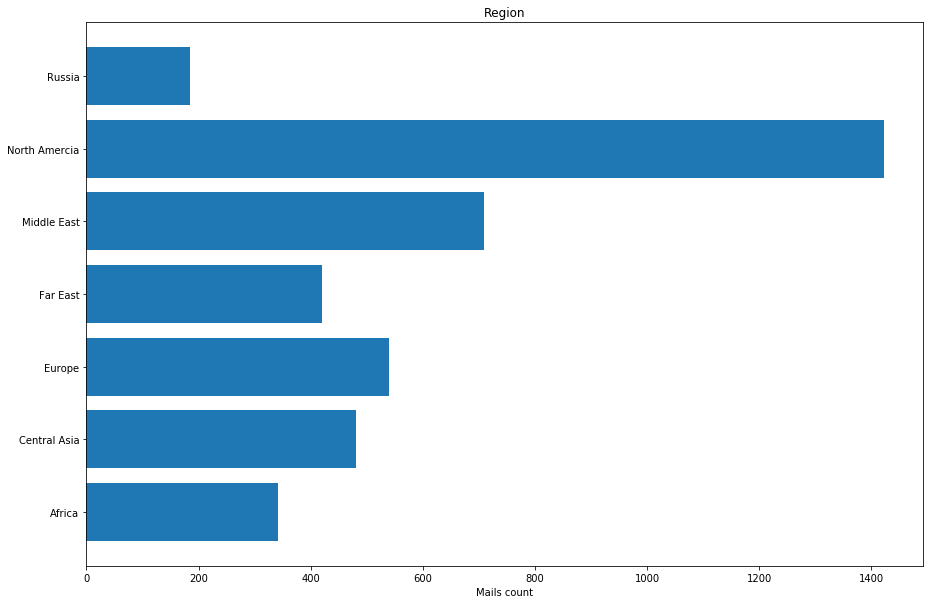

In [30]:
objects = ('Africa', 'Central Asia', 'Europe', 'Far East', 'Middle East', 'North Amercia', 'Russia')
y_pos = np.arange(len(objects))
mail_count = [emails_africa.shape[0], emails_central_asia.shape[0], emails_europe.shape[0], emails_far_east.shape[0], 
              emails_middle_east.shape[0], emails_north_america.shape[0], emails_russia.shape[0]]
 
plt.figure(figsize=(15,10))
plt.barh(y_pos, mail_count, align='center', alpha=1)
plt.yticks(y_pos, objects)
plt.xlabel('Mails count')
plt.title('Region')
 
plt.show()


It seems to be logical that most of the exchanged mails comes from the North America and especially the United State, but in the outside of North America is the Middle East which is quite interesting.

For each region, let's see which words appear the most by analyzing their frequency inspired from this [code](https://www.kaggle.com/edhirif/word-cloud-alternative-using-nltk) .

In [31]:
stop = set(stopwords.words('english'))
stop.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',
             'unclassified', '_', 'us department of state', 'from', 'to', 'subject', 'for', 'doc', 'no','case',
            'state', 'govern','secur', 'sourc', 'date', 'f', 'doc', 'would', 'said', 'also', 'like', 'say'])

In [32]:
#function to extract the most common words from each region
def most_common_word(serie_emails,n):
    '''return the most common words for each mails content'''
    mails_str = serie_emails.str.cat(sep = ' ')
    list_of_words = [i.lower() for i in wordpunct_tokenize(mails_str) if i.lower() not in stop and i.isalpha()]
    wordfreqdist = nltk.FreqDist(list_of_words)
    mostcommon = wordfreqdist.most_common(n)
    return mostcommon

In [33]:
n=30
words_africa = most_common_word(emails_africa,n)
words_central_asia = most_common_word(emails_central_asia,n)
words_europe = most_common_word(emails_europe,n)
words_far_east = most_common_word(emails_far_east,n)
words_middle_east = most_common_word(emails_middle_east,n)
words_latino = most_common_word(emails_latino,n)
words_north_america = most_common_word(emails_north_america,n)
words_russia = most_common_word(emails_russia,n)

Let's use an horizontal bar chart to analyze the word frequency.

In [43]:
#Method to plot the horizontal bar chart for each region
def word_bar_plot(words, string):
    plt.figure(figsize=(15,10))
    plt.barh(range(len(words)),[val[1] for val in words], align='center')
    plt.yticks(range(len(words)), [val[0] for val in words])
    plt.xlabel('Words count')
    plt.title(string)
    plt.show()

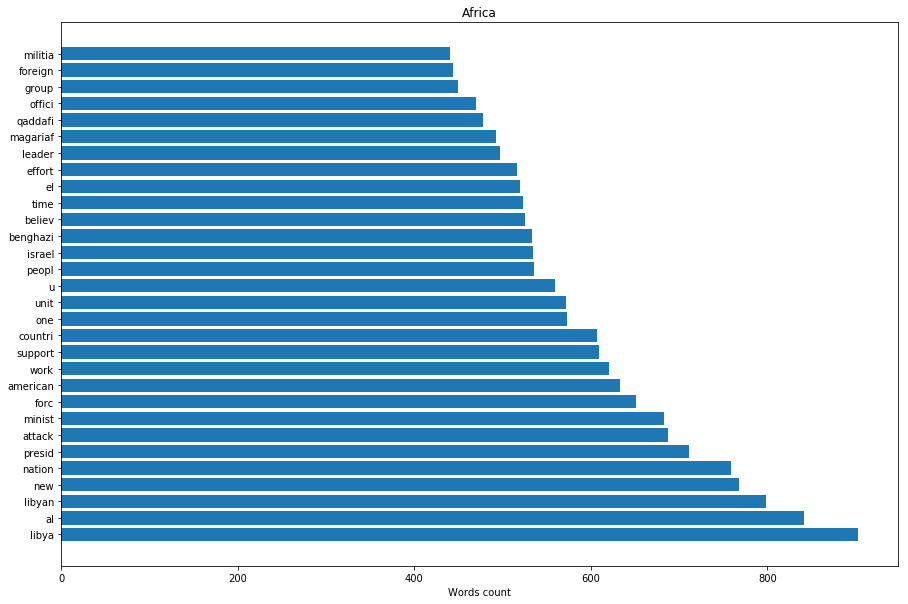

In [44]:
#Horizontal bar chart for Africa
word_bar_plot(words_africa,'Africa')

For Africa, we notice that the most used word is Libya, we notice also that we have also the word Benghati, Gaddafi (qaddafi) and militia. Then if we try to find the date where these emails were sent, we deduce that there is a link with the Arabian Spring (printemps arabe). 

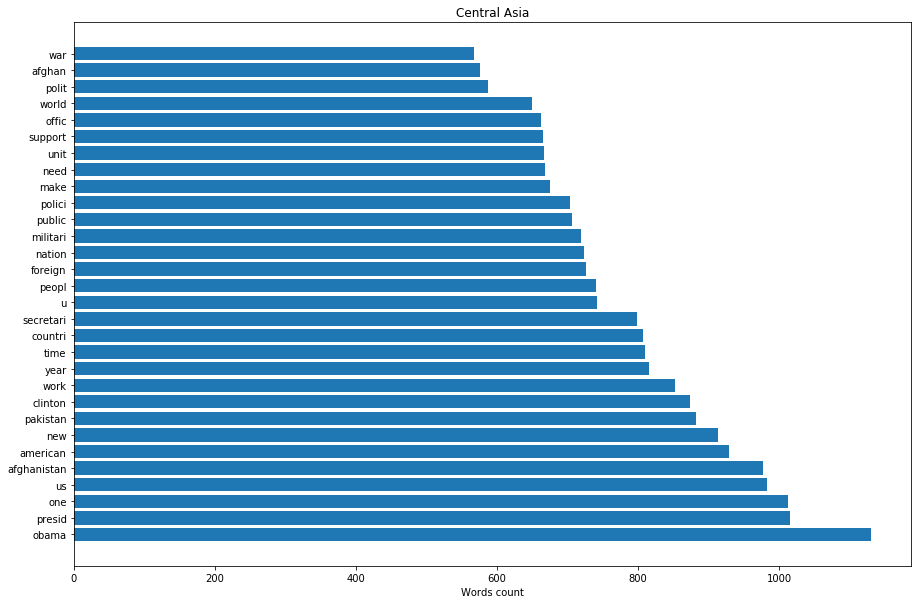

In [46]:
#Horizontal bar chart for central Asia
word_bar_plot(words_central_asia,'Central Asia')

The most word used in central Asia is obama, but we notice also afghanistan, pakistan, militari and war, we get in one case the countries where America is involved in a war and the lexical field of the war.

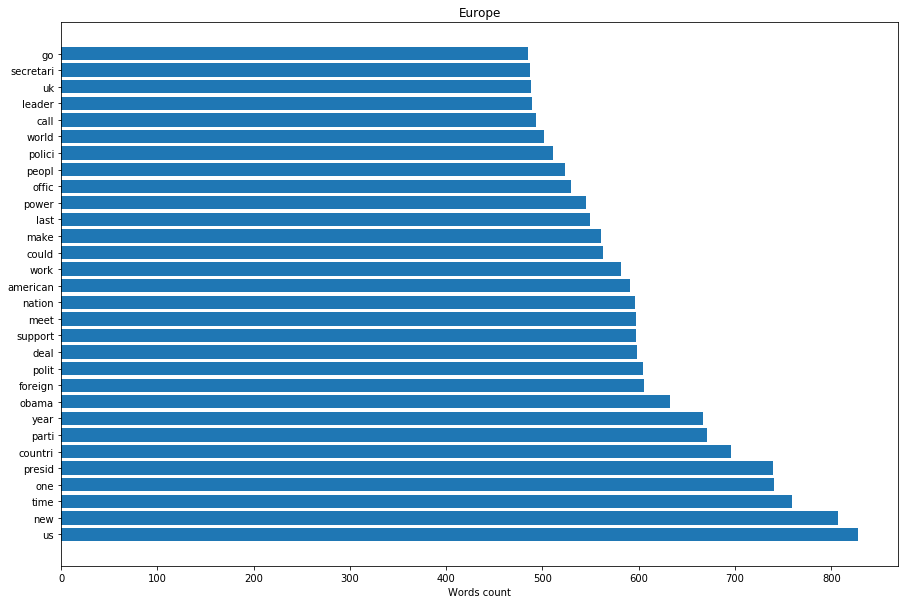

In [47]:
#Horizontal bar chart for Europe
word_bar_plot(words_europe,'Europe')

We notice that there is UK in the common words, if we notice that the mail has been exhanged during 2016, the subject might concerns the Brexit.

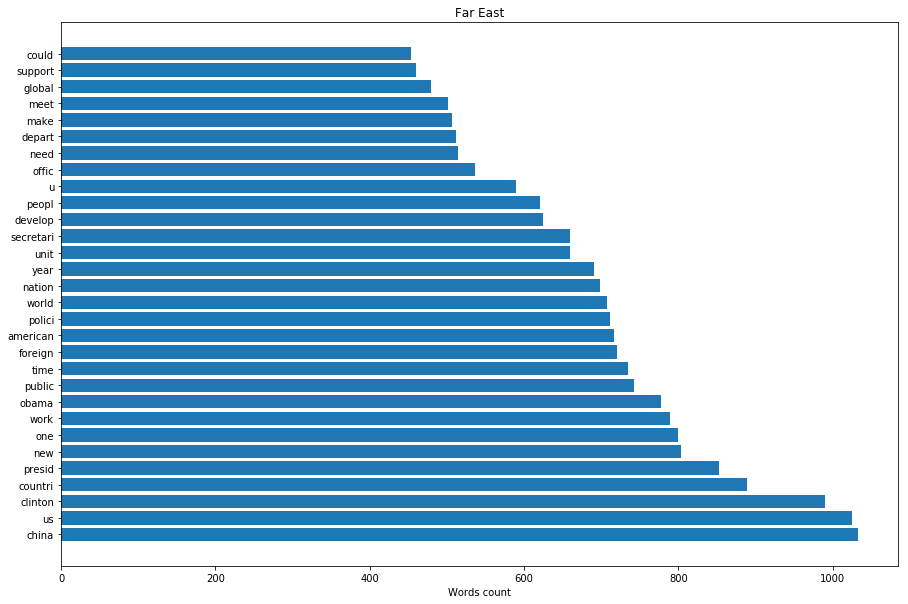

In [48]:
#Horizontal bar chart for Far East
word_bar_plot(words_far_east,'Far East')

In the Far East, the most used word is China without any suprises, since it is the most powerful asian country and there is some issues between USA and China. We notice also obama in this barchart and polici.

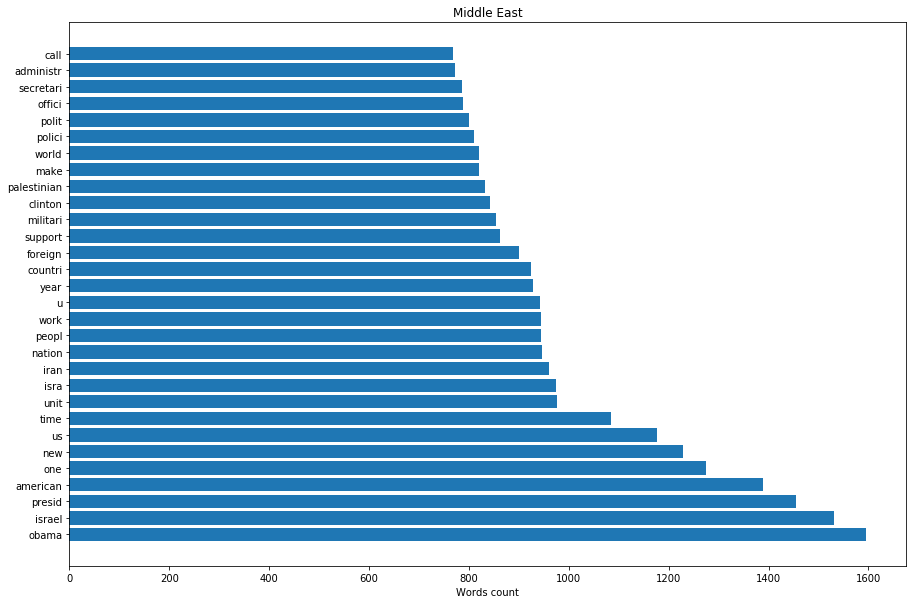

In [49]:
#Horizontal bar chart for Middle East
word_bar_plot(words_middle_east,'Middle East')

Middle east is the part of the world where most the war involved USA, we notice obama, militari. But the most relevant words are palestinian and israel, which is a conflict that is not ended and USA seems to be involved.

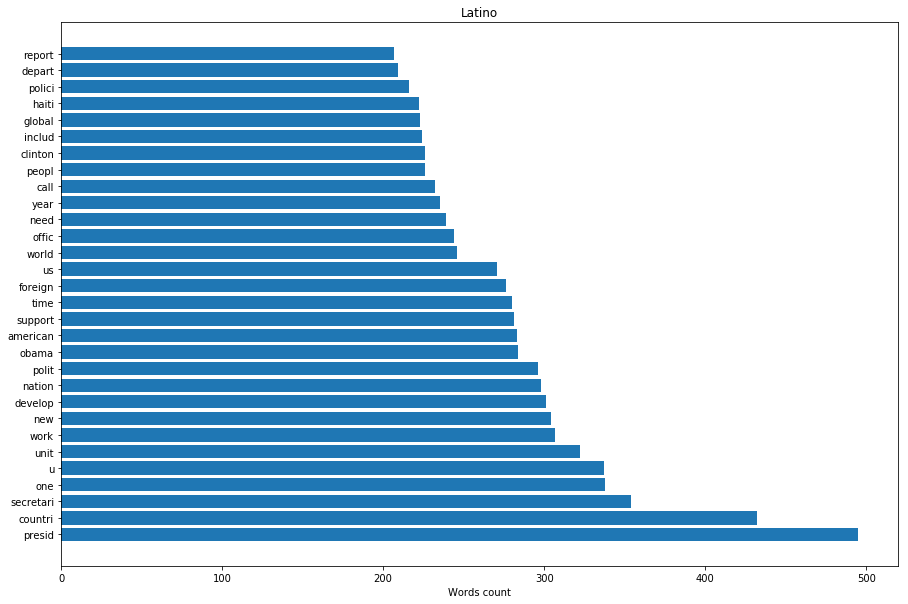

In [50]:
#Horizontal bar chart for Latino
word_bar_plot(words_latino,'Latino')

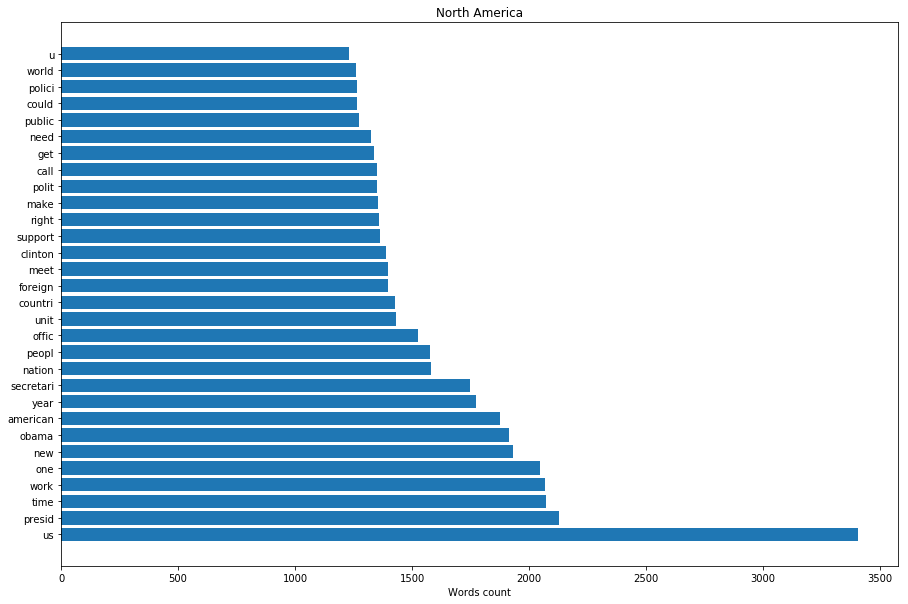

In [51]:
#Horizontal bar chart for North America
word_bar_plot(words_north_america,'North America')

Since these continents are neighboor, then these two continents have many popular words in commmon, we notive us (united states) and presid.

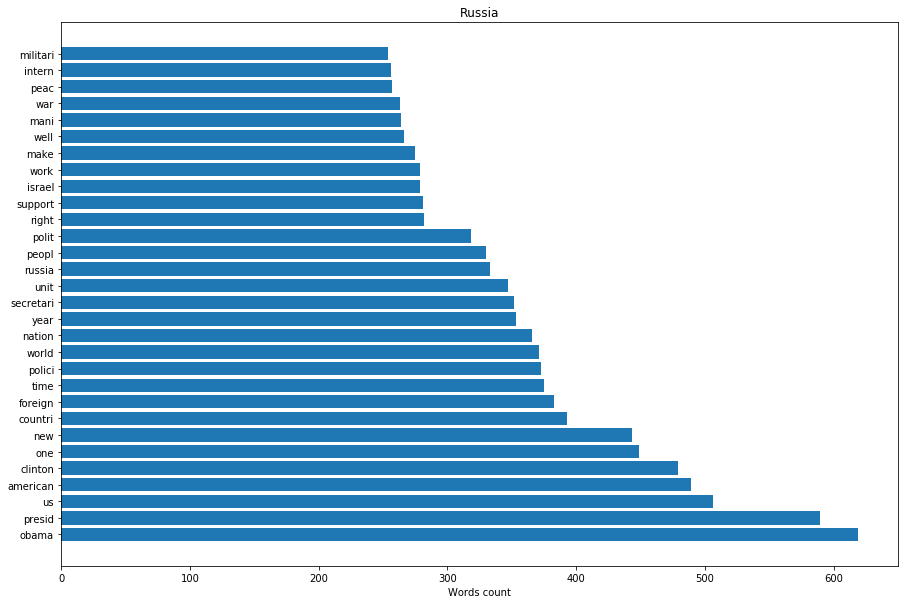

In [52]:
#Horizontal bar chart for Russia
word_bar_plot(words_russia,'Russia')

We notice that obama is also popular in this region, we have also war, support, and also israel. Then one of the subject that has been exchange by mail is the israelo-palestinian conflict.

We can expect that the main subject of each region are the following:
- Africa: Libyan war.
- Central Asia: middle east war, terrorism ?
- Europe: Politics
- Far East: China
- Middel east: Israel-Palestin war.
- North America/Latino: Politics
- Russia: Israel-Palestin war, politics.

### Improve this part: Wordcloud

An another way to vizualize these common words, then we use the function ``WordCloud`` from the package ``wordcloud`` and we use the continent as reference for the wordcloud. We follow this [tutorial](https://www.datacamp.com/community/tutorials/wordcloud-python)

In [147]:
africa_mask = np.array(Image.open("../image/africa_map.png"))

In [149]:
def transform_format(val):
    if val.any() != 225:
        return 225
    else:
        return val

In [150]:
# Transform your mask into a new one that will work with the function:
transformed_africa_mask = np.ndarray((africa_mask.shape[0],africa_mask.shape[1]), np.int32)
for i in range(len(africa_mask)):
    transformed_africa_mask[i] = list(map(transform_format, africa_mask[i]))

In [151]:
words_extract_africa = []
for i in range(len(words_extract_africa)):
    words_extract_africa[i] = words_africa[i][0]

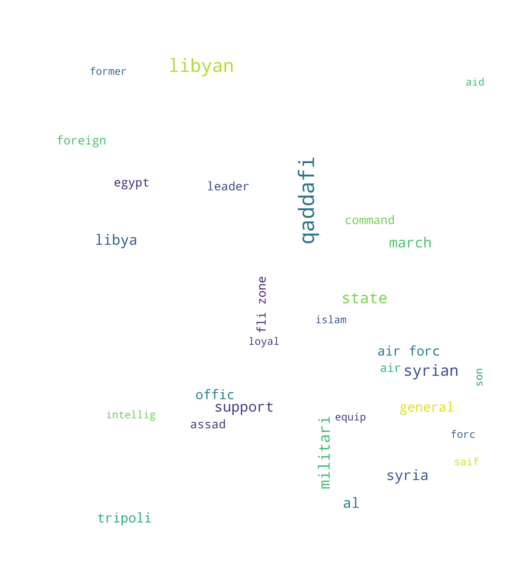

In [152]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=30, mask=transformed_africa_mask,
               stopwords=words_extract_africa, contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc.generate(emails_africa[1])

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

This a first idea for the wordcloud. But it is necessary to find a better image to vizualize or more popular words to vizualize better the african continent and this is only for one email. How can we take every emails ?

## Emails time distribution (with Brice version)

In [34]:
from datetime import datetime

print(emails[['RawText', 'content']].iloc[1]['RawText'])
print(emails[['RawText', 'content']].iloc[1]['content'])

UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739546
Date: 05/13/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN
PART B6
From:
Sent:
To:
Subject:
Attachments:
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
CONFIDENTIAL
March 3, 2011
For: Hillary
From: Sid
Re: Syria aiding Qaddafi
This memo has two parts. Part one is the report that Syria is providing air support for Qaddafi. Part two is a note
to Cody from Lord David Owen, former UK foreign secretary on his views of an increasingly complex crisis. It
seems that the situation is developing into a protracted civil war with various nations backing opposing sides
with unforeseen consequences. Under these circumstances the crucial challenge is to deprive Qaddafi of his
strategic depth—his support bo

In [35]:
emails.MetadataDateSent.dropna(inplace=True)

In [36]:
emails_occurrences= emails.MetadataDateSent.apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))

In [37]:
from collections import Counter
emails_occurences=pd.DataFrame.from_dict(Counter(emails_occurrences), orient='index').reset_index()
emails_occurences.columns = ['date', 'total_sent']
emails_occurences.sort_values(by=['date'], inplace=True)
emails_occurences.set_index('date', inplace=True)


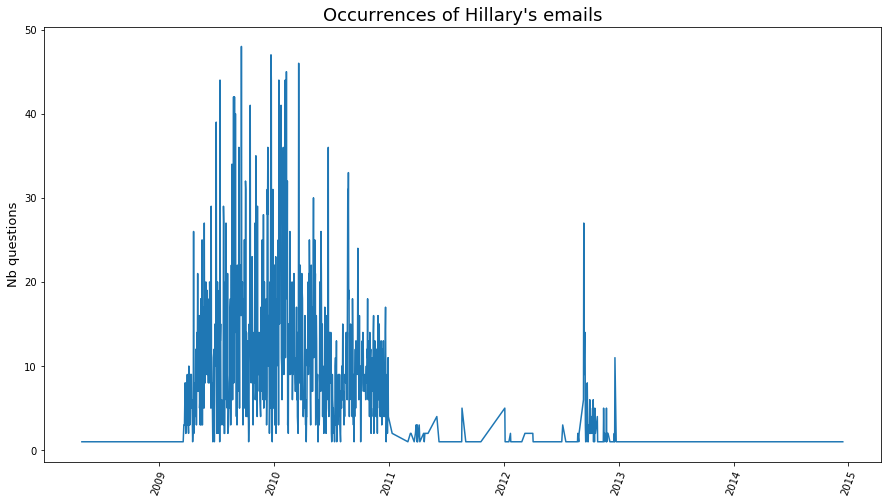

In [38]:
plt.figure(figsize=(15,8))
plt.plot(emails_occurences)
plt.xticks(rotation=70)
plt.title('Occurrences of Hillary\'s emails', size=18)
#plt.xlabel('Time ranges from ' + date_oldest + ' to ' + date_newest, size=13)
plt.ylabel('Nb questions', size=13)
plt.show()

#### Word-frequency

Hereafter, we generate some graphs in order to find which subjects, thematics, etc are the most common related to a specific word. In this Milestone we focus deeper on the text processing that is to be done in order to get informative patterns or results. We generate most of the graphs related to the 'syria' word and try to improve the processing for such a word, and to generalize this processing.

In [39]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data['content'].iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)
            
    return corpus

corpus = build_corpus(emails) 

In [42]:
model = word2vec.Word2Vec(corpus, size=300, window=20, min_count=100, workers=4)
model.wv['syria']

array([-0.0975408 , -0.11974747,  0.00834612,  0.2889268 , -0.14340828,
        0.01501101,  0.13389356, -0.21997534, -0.44415766,  0.03032829,
        0.16972639, -0.14043404, -0.436578  , -0.14460693, -0.01569873,
       -0.07491271, -0.20400466, -0.07814804, -0.17016676, -0.12099447,
        0.0819094 , -0.22668795, -0.05953886, -0.32771444, -0.056672  ,
       -0.10720886,  0.24455991, -0.00938766,  0.09633289, -0.099712  ,
       -0.17304039,  0.3620377 , -0.23749909,  0.09220168, -0.04190819,
        0.155223  , -0.03247223, -0.03833829,  0.04987339,  0.0987229 ,
       -0.17883931, -0.1450408 ,  0.06978166,  0.06117494, -0.1435608 ,
        0.04032573, -0.03926175,  0.05991504,  0.2170976 ,  0.15158512,
       -0.13049918, -0.27447164, -0.46790984,  0.2372934 ,  0.00255774,
       -0.2839248 ,  0.13634399, -0.237516  ,  0.11640454,  0.0218512 ,
        0.18556438,  0.05010875,  0.20998283,  0.08062136, -0.23591042,
       -0.1033569 , -0.01353571,  0.00810639,  0.13663393, -0.07

In [43]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    print(new_values)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


[[ 14.039159   25.924469 ]
 [ 14.145696   -9.559936 ]
 [ 15.432226    2.8658304]
 ...
 [ -5.6838956 -21.467125 ]
 [-36.06096    -5.879763 ]
 [-31.79941   -19.56654  ]]


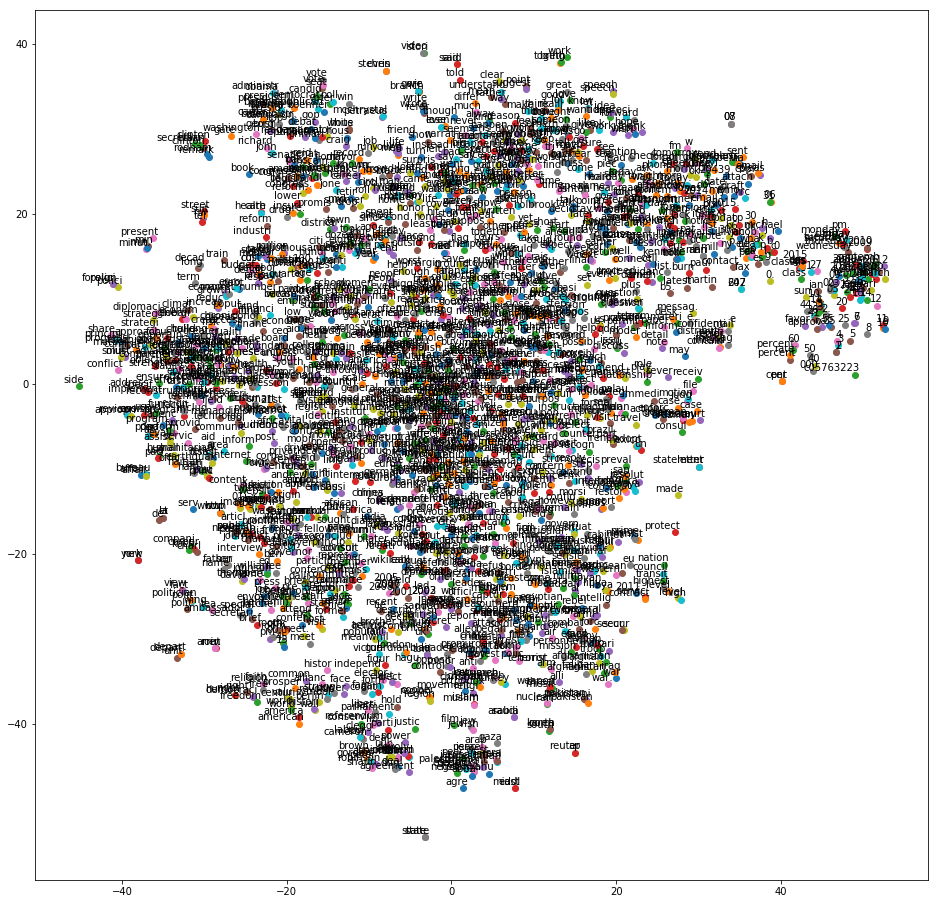

In [44]:
from sklearn.manifold import TSNE

tsne_plot(model)


As we can remark, we have too many words to give the plot unreadable ... Have to figure out

In [45]:
def process_sentence(sentence):
    stop = set(stopwords.words('english'))
    stop.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',
             'unclassified', '_', 'u.s. department of state', 'from', 'to', 'subject', 'for', 'no','case',
            'state', 'govern','secur', 'sourc', 'date', 'f', 'doc', 'would', 'said', 'also', 'like', 'say', 'www', 'com', 'doc', 'http'])
    try:
        sentence= re.sub(r'[0-9]+', '', sentence)
        sentence = [w for w in sentence.split(' ') if w not in stop]
        sentence = ' '.join(sentence)
        return sentence
    except:
        return 'null'

In [46]:
def word_bar_plot(words, string):
    plt.figure(figsize=(15,10))
    plt.barh(range(len(words)),[val[1] for val in words], align='center')
    plt.yticks(range(len(words)), [val[0] for val in words])
    plt.xlabel('Words count')
    plt.title(string)
    plt.show()

In [47]:
def wordcloud_visualization(frequencies):
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=frequencies)
    plt.figure( figsize=(5,3) )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [48]:
def get_top_n_words(corpus, words='ALL', n=None, tf_idf=True, plot=True):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    if words!='ALL':
        is_in = corpus.apply(lambda x: True if words in x else False)
        corpus = corpus[is_in.values]
        
    corpus = corpus.apply(lambda x: process_sentence(x))
    if tf_idf:
        vec= TfidfVectorizer(ngram_range=(2,2)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    if plot:
        d = {}
        for a, x in w:
            d[a] =x
        word_bar_plot(words_freq[:n], words)
        wordcloud_visualization(d)
    return words_freq[:n]

In [ ]:
top_words = get_top_n_words(emails.content, 'ALL', 1000)
words_to_remove=[]
for k,v in top_words:
    words_to_remove.append(k)

In [ ]:
w=get_top_n_words(emails.content, 'syria', 50)

### Vizualisation (TODO)

In [ ]:
model = Word2Vec.load('model_word2vec.bin')

In [ ]:
model.wv.most_similar(positive="compani") # after stemming

In [ ]:
X = model.wv[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [ ]:
# TODO: do not display points which do not have annotations.
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
words_to_display = ["britain", "franc", "libya", "russia", "merkel", "sarkozi", "oil", "lobbi", "terrorist"]
for i, word in enumerate(words):
    if word in words_to_display:
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

### 3. Pre-results

    3.1. Adjacency matrix (Hillary's network) construction